# Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import os
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import scipy
from torchinfo import summary
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import raw data

In [ ]:
#Defining function to check if directory exists, if not it generates it
def check_and_make_dir(dir):
    if not os.path.isdir(dir):os.mkdir(dir)

#Base directory 
base_dir = '/Users/samsonmercier/Desktop/Work/PhD/Research/Second_Generals/'
# File containing temperature values
raw_T_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_T.csv', delimiter=',')
#File containing pressure values
raw_P_data = np.loadtxt(base_dir+'Data/bt-4500k/training_data_P.csv', delimiter=',')

#Path to load NN model
NN_model_load_path = base_dir+'Model_Storage/NN_server_stand_norm/'

#Path to store comparison plots
plot_save_path = base_dir+'Plots/GP_vs_NN/'
check_and_make_dir(plot_save_path)

#Last 51 columns are the temperature/pressure values, 
#First 5 are the input values (H2 pressure in bar, CO2 pressure in bar, LoD in hours, Obliquity in deg, H2+Co2 pressure) but we remove the last one since it's not adding info.
raw_inputs = raw_T_data[:, :4]
raw_outputs_T = raw_T_data[:, 5:]
raw_outputs_P = raw_P_data[:, 5:]

#Convert raw outputs to log10 scale so we don't have to deal with it later
raw_outputs_P = np.log10(raw_outputs_P/1000)

#Storing useful quantitites
N = raw_inputs.shape[0] #Number of data points
D = raw_inputs.shape[1] #Number of features
O = raw_outputs_T.shape[1] #Number of outputs

## HYPER-PARAMETERS ##
#Defining partition of data used for 1. training, 2. validation and 3. testing
data_partitions = [0.7, 0.1, 0.2]

#Defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_threads = 1
torch.set_num_threads(num_threads)
print(f"Using {device} device with {num_threads} threads")
torch.set_default_device(device)

#Defining the noise seed for the random partitioning of the training data
partition_seed = 4
rng = torch.Generator(device=device)
rng.manual_seed(partition_seed)

# Variable to show plots or not 
show_plot = False

## GP
#Number of nearest neighbors to choose
N_neigbors = 10

#Distance metric to use
distance_metric = 'euclidean' #options: 'euclidean', 'mahalanobis', 'logged_euclidean', 'logged_mahalanobis'

#Convert raw inputs for H2 and CO2 pressures to log10 scale so don't have to deal with it later
if 'logged' in distance_metric:
    raw_inputs[:, 0] = np.log10(raw_inputs[:, 0]) #H2
    raw_inputs[:, 1] = np.log10(raw_inputs[:, 1]) #CO2

## NN
#Neural network width and depth
nn_width = 102
nn_depth = 5

#Optimizer learning rate
learning_rate = 1e-3

#Regularization coefficient
regularization_coeff = 0.0

#Weight decay 
weight_decay = 0.0

#Batch size 
batch_size = 200

#Number of epochs 
n_epochs = 200000

# Partition data and build Data Module

In [ ]:
# PyTorch Lightning DataModule
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_inputs, train_outputs, valid_inputs, valid_outputs, test_inputs, test_outputs, batch_size, rng):
        super().__init__()

        # Standardizing the output
        ## Create scaler
        out_scaler = StandardScaler()
        
        ## Fit scaler on training dataset (convert to numpy)
        out_scaler.fit(train_outputs.numpy())
        
        ## Transform all datasets and convert back to tensors
        train_outputs = torch.tensor(out_scaler.transform(train_outputs.numpy()), dtype=torch.float32)
        valid_outputs = torch.tensor(out_scaler.transform(valid_outputs.numpy()), dtype=torch.float32)
        test_outputs = torch.tensor(out_scaler.transform(test_outputs.numpy()), dtype=torch.float32)
        
        # Store the scaler if you need to inverse transform later
        self.out_scaler = out_scaler
        
        # Normalizing the input
        ## Create scaler
        in_scaler = MinMaxScaler()
        
        ## Fit scaler on training dataset (convert to numpy)
        in_scaler.fit(train_inputs.numpy())
        
        ## Transform all datasets and convert back to tensors
        train_inputs = torch.tensor(in_scaler.transform(train_inputs.numpy()), dtype=torch.float32)
        valid_inputs = torch.tensor(in_scaler.transform(valid_inputs.numpy()), dtype=torch.float32)
        test_inputs = torch.tensor(in_scaler.transform(test_inputs.numpy()), dtype=torch.float32)
        
        # Store the scaler if you need to inverse transform later
        self.in_scaler = in_scaler

        # Storing it and passing it to loaders
        self.train_inputs = train_inputs
        self.train_outputs = train_outputs
        self.valid_inputs = valid_inputs
        self.valid_outputs = valid_outputs
        self.test_inputs = test_inputs
        self.test_outputs = test_outputs
        self.batch_size = batch_size
        self.rng = rng
    
    def train_dataloader(self):
        dataset = TensorDataset(self.train_inputs, self.train_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=self.rng)
    
    def val_dataloader(self):
        dataset = TensorDataset(self.valid_inputs, self.valid_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)

    def test_dataloader(self):
        dataset = TensorDataset(self.test_inputs, self.test_outputs)
        return DataLoader(dataset, batch_size=self.batch_size, generator=self.rng)

#Splitting the data 

## Retrieving indices of data partitions
train_idx, valid_idx, test_idx = torch.utils.data.random_split(range(N), data_partitions, generator=rng)

## Generate the data partitions
### Training
train_inputs = torch.tensor(raw_inputs[train_idx], dtype=torch.float32)
train_outputs_T = torch.tensor(raw_outputs_T[train_idx], dtype=torch.float32)
train_outputs_P = torch.tensor(raw_outputs_P[train_idx], dtype=torch.float32)
### Validation
valid_inputs = torch.tensor(raw_inputs[valid_idx], dtype=torch.float32)
valid_outputs_T = torch.tensor(raw_outputs_T[valid_idx], dtype=torch.float32)
valid_outputs_P = torch.tensor(raw_outputs_P[valid_idx], dtype=torch.float32)
### Testing
test_inputs = torch.tensor(raw_inputs[test_idx], dtype=torch.float32)
test_outputs_T = torch.tensor(raw_outputs_T[test_idx], dtype=torch.float32)
test_outputs_P = torch.tensor(raw_outputs_P[test_idx], dtype=torch.float32)

## Concatenating outputs
train_outputs = torch.cat([
    train_outputs_T,
    train_outputs_P
], dim=1)

valid_outputs = torch.cat([
    valid_outputs_T,
    valid_outputs_P
], dim=1)

test_outputs = torch.cat([
    test_outputs_T,
    test_outputs_P
], dim=1)

# Create DataModule
data_module = CustomDataModule(
    train_inputs, train_outputs,
    valid_inputs, valid_outputs,
    test_inputs, test_outputs,
    batch_size, rng
)

# Fit data with Ensemble Conditional GP

## Build Conditional GP function

In [ ]:
def Sai_CGP(obs_features, obs_labels, query_features):
    """
    Conditional Gaussian Process
    Inputs: 
        obs_features : ndarray (D, N)
            D-dimensional features of the N ensemble data points.
        obs_labels : ndarray (K, N)
            K-dimensional labels of the N ensemble data points.
        query_features : ndarray (D, 1)
            D-dimensional features of the query data point.
    Outputs:
        query_labels : ndarray (K, N)
            K-dimensional labels of the ensemble updated from the query point.
        query_cov_labels : ndarray (K, K)
            K-by-K covariance of the ensemble labels.
    """
    
    # Defining relevant covariance matrices
    ## Between feature and label of observation data
    Cyx = (obs_labels @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and feature of observation data
    Cxy = (obs_features @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Between feature and feature of observation data
    Cxx = (obs_features @ obs_features.T) / (obs_features.shape[0] - 1)
    ## Between label and label of observation data
    Cyy = (obs_labels @ obs_labels.T) / (obs_features.shape[0] - 1)
    ## Adding regularizer to avoid singularities
    Cxx += 1e-7 * np.eye(Cxx.shape[0]) 

    query_labels = obs_labels + (Cyx @ scipy.linalg.pinv(Cxx) @ (query_features - obs_features))

    query_cov_labels = Cyy - Cyx @ scipy.linalg.pinv(Cxx) @ Cxy

    return query_labels, query_cov_labels

## Evaluating GP approach on test set

In [ ]:
#Initialize array to store model outputs
test_GP_outputs_T = np.zeros(test_outputs_T.shape, dtype=float)
test_GP_outputs_P = np.zeros(test_outputs_P.shape, dtype=float)

GP_train_inputs = np.copy(train_inputs.numpy())
GP_train_outputs_T = np.copy(train_outputs_T.numpy())
GP_train_outputs_P = np.copy(train_outputs_P.numpy())

for query_idx, (test_input, test_output_T, test_output_P) in enumerate(zip(test_inputs.numpy(), test_outputs_T.numpy(), test_outputs_P.numpy())):

    #Calculate proximity of query point to observations
    # Euclidian distance
    if 'euclidean' in distance_metric:
        distances = np.sqrt( (test_input[0] - GP_train_inputs[:,0])**2 + (test_input[1] - GP_train_inputs[:,1])**2 + (test_input[2] - GP_train_inputs[:,2])**2 + (test_input[3] - GP_train_inputs[:,3])**2 )
    # Mahalanobis distance
    elif 'mahalanobis' in distance_metric:
        distances = np.sqrt( (test_input - np.mean(GP_train_inputs, axis=0)).T @ scipy.linalg.inv((GP_train_inputs.T @ GP_train_inputs) / (GP_train_inputs.shape[0] - 1)) @ (test_input - np.mean(GP_train_inputs, axis=0)) )
    else:raise('Invalid distance metric')
    
    #Choose the N closest points
    N_closest_idx = np.argsort(distances)[:N_neigbors]
    prox_train_inputs = GP_train_inputs[N_closest_idx, :]
    prox_train_outputs_T = GP_train_outputs_T[N_closest_idx, :]
    prox_train_outputs_P = GP_train_outputs_P[N_closest_idx, :]
    
    #Find the query labels from nearest neigbours
    mean_test_output, cov_test_output = Sai_CGP(prox_train_inputs.T, np.concat((prox_train_outputs_T, prox_train_outputs_P), axis=1).T, test_input.reshape((1, 4)).T)
    test_GP_outputs_T[query_idx, :] = np.mean(mean_test_output[:O], axis=1)
    test_GP_outputs_P[query_idx, :] = np.mean(mean_test_output[O:], axis=1)
    model_test_output_Terr = np.sqrt(np.diag(cov_test_output))[:O]
    model_test_output_Perr = np.sqrt(np.diag(cov_test_output))[O:]

    #Diagnostic plot
    if show_plot:

        #Plot TP profiles
        fig, axs = plt.subplot_mosaic([['res_pressure', '.'],
                                       ['results', 'res_temperature']],
                              figsize=(8, 6),
                              width_ratios=(3, 1), height_ratios=(1, 3),
                              layout='constrained')
        for prox_idx in range(N_neigbors):
            axs['results'].plot(prox_train_outputs_T[prox_idx], prox_train_outputs_P[prox_idx], '.', linestyle='-', color='red', alpha=0.1, linewidth=2, zorder=1, label='Ensemble' if prox_idx==0 else None)
        for t,p in zip(mean_test_output[:O],mean_test_output[O:]):axs['results'].plot(t, p, '.', linestyle='-', color='green', alpha=0.1, linewidth=2, markersize=10, zorder=2)
        axs['results'].plot(test_GP_outputs_T[query_idx, :], test_GP_outputs_P[query_idx, :], '.', linestyle='-', color='black', linewidth=2, markersize=10, zorder=2, label='Ensemble Mean')
        axs['results'].errorbar(test_GP_outputs_T[query_idx, :], test_GP_outputs_P[query_idx, :], xerr=model_test_output_Terr, yerr=model_test_output_Perr, fmt='.', linestyle='-', color='black', linewidth=2, zorder=2, alpha=0.2, markersize=10)
        axs['results'].plot(test_output_T, test_output_P, '.', linestyle='-', color='blue', linewidth=2, zorder=2, markersize=10, label='Truth')
        axs['results'].invert_yaxis()
        axs['results'].set_ylabel(r'log$_{10}$ Pressure (bar)')
        axs['results'].set_xlabel('Temperature (K)')
        axs['results'].grid()
        axs['results'].legend()        
        
        axs['res_temperature'].fill_betweenx(test_output_P, test_GP_outputs_T[query_idx, :] - test_output_T - model_test_output_Terr, test_GP_outputs_T[query_idx, :] - test_output_T + model_test_output_Terr, color='green', alpha=0.4)
        axs['res_temperature'].plot(test_GP_outputs_T[query_idx, :] - test_output_T, test_output_P, '.', linestyle='-', color='green', linewidth=2)
        axs['res_temperature'].axvline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_temperature'].invert_yaxis()
        axs['res_temperature'].set_xlabel('Residuals (K)')
        axs['res_temperature'].yaxis.tick_right()
        axs['res_temperature'].yaxis.set_label_position("right")
        axs['res_temperature'].grid()

        axs['res_pressure'].fill_between(test_output_T, test_GP_outputs_P[query_idx, :] - test_output_P - model_test_output_Perr, test_GP_outputs_P[query_idx, :] - test_output_P + model_test_output_Perr, color='green', alpha=0.4)
        axs['res_pressure'].plot(test_GP_outputs_P[query_idx, :] - test_output_P, test_output_P, '.', linestyle='-', color='green', linewidth=2)
        axs['res_pressure'].axhline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_pressure'].invert_yaxis()
        axs['res_pressure'].set_ylabel('Residuals (bar)')
        axs['res_pressure'].xaxis.tick_top()
        axs['res_pressure'].xaxis.set_label_position("top")
        axs['res_pressure'].grid()

        plt.suptitle(rf'H$_2$ : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.subplots_adjust(hspace=0, wspace=0)
        plt.show()

# Import NN model

## Build MLP

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth):
        super().__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        # Hidden layers
        for _ in range(depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        # Pack all layers into a Sequential container
        self.linear_relu_stack = nn.Sequential(*layers)
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork(D, nn_width, 2*O, nn_depth).to(device)
summary(model)

## Define optimization block

In [ ]:
# PyTorch Lightning Module
class RegressionModule(pl.LightningModule):
    def __init__(self, model, optimizer, learning_rate, weight_decay=0.0, reg_coeff=0.0):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.reg_coeff = reg_coeff
        self.weight_decay = weight_decay
        self.loss_fn = nn.MSELoss()
        self.optimizer_class = optimizer
    
    def compute_gradient_penalty(self, X):
        """
        Compute the gradient of model output with respect to input.
        Returns the L2 norm of the gradients as a regularization term.
        """
        if self.reg_coeff == 0:
            return torch.tensor(0., device=self.device)
        
        # Clone and enable gradient computation for inputs
        X_grad = X.clone().detach().requires_grad_(True)

        # Temporarily enable gradients (needed for validation/test steps)
        with torch.enable_grad():
            
            # Compute output (need to recompute to track gradients w.r.t. X)
            output = self.model(X_grad)
            
            # Compute gradients of output with respect to input
            grad_outputs = torch.ones_like(output)
            gradients = torch.autograd.grad(
                outputs=output,
                inputs=X_grad,
                grad_outputs=grad_outputs,
                create_graph=True,  # Keep computation graph for backprop
                retain_graph=True,
                only_inputs=True
            )[0]
            
            # Compute L2 norm of gradients (squared)
            gradient_penalty = torch.mean(gradients ** 2)
        
        return self.reg_coeff * gradient_penalty
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)
        
        # Add gradient regularization
        grad_penalty = self.compute_gradient_penalty(X)
        loss += grad_penalty

        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)

        # Log metrics
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        X, y = batch
        pred = self(X)
        loss = self.loss_fn(pred, y)

        # Log metrics
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer_class(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

## Retrieve optimization

In [ ]:
# Create Lightning Module
lightning_module = RegressionModule(
    model=model,
    optimizer=SGD,
    learning_rate=learning_rate,
    reg_coeff=regularization_coeff,
    weight_decay=weight_decay
)

# Setup logger
logger = CSVLogger(NN_model_load_path+'logs', name='NeuralNetwork')

# Create Trainer and train
trainer = Trainer(
    max_epochs=n_epochs,
    logger=logger,
    deterministic=True  # For reproducibility
)

# Load model
lightning_module = RegressionModule.load_from_checkpoint(
    NN_model_load_path + f'{n_epochs}epochs_{regularization_coeff}WD_{regularization_coeff}RC_{learning_rate}LR_{batch_size}BS.ckpt',
    model=model,
    optimizer=SGD,
learning_rate=learning_rate,
reg_coeff=regularization_coeff,
weight_decay=weight_decay
)
print("Model loaded!")

## Diagnostic plots

In [ ]:
#Comparing predicted T-P profiles vs true T-P profiles with residuals
substep = 100

# Get the scalers from data module
out_scaler = data_module.out_scaler
in_scaler = data_module.in_scaler

#Initialize array to store model outputs
test_NN_outputs_T = np.zeros(test_outputs_T.shape, dtype=float)
test_NN_outputs_P = np.zeros(test_outputs_P.shape, dtype=float)

for test_idx, (test_input, test_output_T, test_output_P) in enumerate(zip(test_inputs.numpy(), test_outputs_T.numpy(), test_outputs_P.numpy())):

    #Retrieve prediction
    pred_output = model(torch.tensor(in_scaler.transform(test_input.reshape(1, -1)))).detach().numpy()
    
    # Inverse transform to get original scale
    pred_output_original = out_scaler.inverse_transform(pred_output.reshape(1, -1)).flatten()
    
    # Split back into T and P components
    test_NN_outputs_T[test_idx, :] = pred_output_T = pred_output_original[:O]
    test_NN_outputs_P[test_idx, :] = pred_output_P = pred_output_original[O:]

    #Plotting
    if (test_idx % substep == 0):
        fig, axs = plt.subplot_mosaic([['res_pressure', '.'],
                                       ['results', 'res_temperature']],
                              figsize=(8, 6),
                              width_ratios=(3, 1), height_ratios=(1, 3),
                              layout='constrained')        
        axs['results'].plot(test_output_T, test_output_P, '.', linestyle='-', color='blue', linewidth=2)
        axs['results'].plot(test_NN_outputs_T[test_idx, :], test_NN_outputs_P[test_idx, :], color='green', linewidth=2)
        axs['results'].invert_yaxis()
        axs['results'].set_ylabel(r'log$_{10}$ Pressure (bar)')
        axs['results'].set_xlabel('Temperature (K)')
        axs['results'].legend()
        axs['results'].grid()

        axs['res_temperature'].plot(test_NN_outputs_T[test_idx, :] - test_output_T, test_output_P, '.', linestyle='-', color='green', linewidth=2)
        axs['res_temperature'].set_xlabel('Residuals (K)')
        axs['res_temperature'].invert_yaxis()
        axs['res_temperature'].grid()
        axs['res_temperature'].axvline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_temperature'].yaxis.tick_right()
        axs['res_temperature'].yaxis.set_label_position("right")
        axs['res_temperature'].sharey(axs['results'])

        axs['res_pressure'].plot(test_output_T, test_NN_outputs_P[test_idx, :] - test_output_P, '.', linestyle='-', color='green', linewidth=2)
        axs['res_pressure'].set_ylabel('Residuals (bar)')
        axs['res_pressure'].invert_yaxis()
        axs['res_pressure'].grid()
        axs['res_pressure'].axhline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_pressure'].xaxis.tick_top()
        axs['res_pressure'].xaxis.set_label_position("top")
        axs['res_pressure'].sharex(axs['results'])

        plt.suptitle(rf'H$_2$ : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.show()
    

# Compare both methods

In [ ]:
#Comparing GP predicted T-P profiles vs NN predicted T-P profiles vs true T-P profiles
substep = 100

#Initialize array to store model residuals
res_NN_outputs_T = np.zeros(test_outputs_T.shape, dtype=float)
res_NN_outputs_P = np.zeros(test_outputs_P.shape, dtype=float)
res_GP_outputs_T = np.zeros(test_outputs_T.shape, dtype=float)
res_GP_outputs_P = np.zeros(test_outputs_P.shape, dtype=float)

for test_idx, (test_input, test_output_T, test_output_P) in enumerate(zip(test_inputs.numpy(), test_outputs_T.numpy(), test_outputs_P.numpy())):
    
    #Store residuals 
    res_NN_outputs_T[test_idx, :] = test_NN_outputs_T[test_idx, :] - test_output_T
    res_NN_outputs_P[test_idx, :] = test_NN_outputs_P[test_idx, :] - test_output_P
    res_GP_outputs_T[test_idx, :] = test_GP_outputs_T[test_idx, :] - test_output_T
    res_GP_outputs_P[test_idx, :] = test_GP_outputs_P[test_idx, :] - test_output_P

    #Plotting
    if (test_idx % substep == 0):
        fig, axs = plt.subplot_mosaic([['res_pressure', '.'],
                                       ['results', 'res_temperature']],
                              figsize=(8, 6),
                              width_ratios=(3, 1), height_ratios=(1, 3),
                              layout='constrained')   
             
        axs['results'].plot(test_output_T, test_output_P, '.', linestyle='-', color='blue', label='Truth', linewidth=2)
        axs['results'].plot(test_NN_outputs_T[test_idx, :], test_NN_outputs_P[test_idx, :], color='green', label='Neural Network', linewidth=2)
        axs['results'].plot(test_GP_outputs_T[test_idx, :], test_GP_outputs_P[test_idx, :], color='red', label='Ens. Gauss. Process ', linewidth=2)
        axs['results'].invert_yaxis()
        axs['results'].set_ylabel(r'log$_{10}$ Pressure (bar)')
        axs['results'].set_xlabel('Temperature (K)')
        axs['results'].legend()
        axs['results'].grid()

        axs['res_temperature'].plot(res_NN_outputs_T[test_idx, :], test_output_P, '.', linestyle='-', color='green', linewidth=2)
        axs['res_temperature'].plot(res_GP_outputs_T[test_idx, :], test_output_P, '.', linestyle='-', color='red', linewidth=2)
        axs['res_temperature'].set_xlabel('Residuals (K)')
        axs['res_temperature'].invert_yaxis()
        axs['res_temperature'].grid()
        axs['res_temperature'].axvline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_temperature'].yaxis.tick_right()
        axs['res_temperature'].yaxis.set_label_position("right")
        axs['res_temperature'].sharey(axs['results'])

        axs['res_pressure'].plot(test_output_T, res_NN_outputs_P[test_idx, :], '.', linestyle='-', color='green', linewidth=2)
        axs['res_pressure'].plot(test_output_T, res_GP_outputs_P[test_idx, :], '.', linestyle='-', color='red', linewidth=2)
        axs['res_pressure'].set_ylabel('Residuals (bar)')
        axs['res_pressure'].invert_yaxis()
        axs['res_pressure'].grid()
        axs['res_pressure'].axhline(0, color='black', linestyle='dashed', zorder=2)
        axs['res_pressure'].xaxis.tick_top()
        axs['res_pressure'].xaxis.set_label_position("top")
        axs['res_pressure'].sharex(axs['results'])

        plt.suptitle(rf'H$_2$ : {test_input[0]} bar, CO$_2$ : {test_input[1]} bar, LoD : {test_input[2]:.0f} days, Obliquity : {test_input[3]} deg')
        plt.savefig(plot_save_path+f'/pred_vs_actual_n.{test_idx}.pdf')
    

--- GP Residuals ---
Temperature Residuals : Median = 0.0028 K, Std = 10.0480 K
Pressure Residuals : Median = 0.000011 $log_10$ bar, Std = 0.038542 $log_10$ bar

 --- NN Residuals ---
Temperature Residuals : Median = -1.0397 K, Std = 4.7834 K
Pressure Residuals : Median = -0.000196 $log_10$ bar, Std = 0.011064 $log_10$ bar


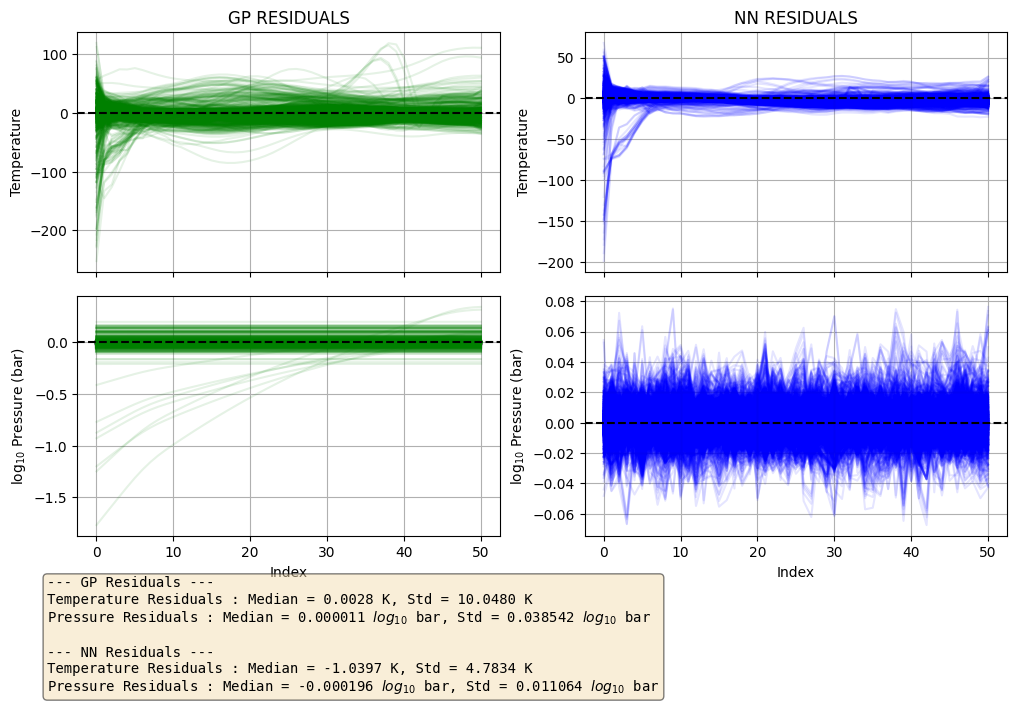

In [16]:
print('--- GP Residuals ---')
print(f'Temperature Residuals : Median = {np.median(res_GP_outputs_T):.4f} K, Std = {np.std(res_GP_outputs_T):.4f} K')
print(rf'Pressure Residuals : Median = {np.median(res_GP_outputs_P):.6f} $log_{10}$ bar, Std = {np.std(res_GP_outputs_P):.6f} $log_{10}$ bar')
print('\n','--- NN Residuals ---')
print(f'Temperature Residuals : Median = {np.median(res_NN_outputs_T):.4f} K, Std = {np.std(res_NN_outputs_T):.4f} K')
print(rf'Pressure Residuals : Median = {np.median(res_NN_outputs_P):.6f} $log_{10}$ bar, Std = {np.std(res_NN_outputs_P):.6f} $log_{10}$ bar')

#Plot residuals
fig, ((ax1, ax3),(ax2,ax4)) = plt.subplots(2, 2, sharex=True, figsize=[12, 8])
ax1.plot(res_GP_outputs_T.T, alpha=0.1, color='green')
ax2.plot(res_GP_outputs_P.T, alpha=0.1, color='green')
ax3.plot(res_NN_outputs_T.T, alpha=0.1, color='blue')
ax4.plot(res_NN_outputs_P.T, alpha=0.1, color='blue')
ax1.set_title('GP RESIDUALS')
ax3.set_title('NN RESIDUALS')
for ax in [ax1, ax2, ax3, ax4]:
    ax.axhline(0, color='black', linestyle='dashed')
    ax.grid()
ax2.set_xlabel('Index')
ax4.set_xlabel('Index')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('log$_{10}$ Pressure (bar)')
ax3.set_ylabel('Temperature')
ax4.set_ylabel('log$_{10}$ Pressure (bar)')
plt.subplots_adjust(hspace=0.1, bottom=0.25)

# Add statistics text at the bottom
stats_text = (
    f"--- GP Residuals ---\n"
    f"Temperature Residuals : Median = {np.median(res_GP_outputs_T):.4f} K, Std = {np.std(res_GP_outputs_T):.4f} K\n"
    f"Pressure Residuals : Median = {np.median(res_GP_outputs_P):.6f} $log_{{10}}$ bar, Std = {np.std(res_GP_outputs_P):.6f} $log_{{10}}$ bar\n"
    f"\n"
    f"--- NN Residuals ---\n"
    f"Temperature Residuals : Median = {np.median(res_NN_outputs_T):.4f} K, Std = {np.std(res_NN_outputs_T):.4f} K\n"
    f"Pressure Residuals : Median = {np.median(res_NN_outputs_P):.6f} $log_{{10}}$ bar, Std = {np.std(res_NN_outputs_P):.6f} $log_{{10}}$ bar"
)

fig.text(0.1, 0.05, stats_text, fontsize=10, family='monospace',
         verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig(plot_save_path+f'/res_GP_vs_NN.pdf', bbox_inches='tight')
plt.show()